In [1]:
import os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
d = os.getcwd()
p = os.path.dirname(d)

sys.path.append(p)

In [3]:
from src.dynamics import RobotWorld
from src.lqr import Lqr
from src.algorithms.addpgpd_sampled import ADpgpdSampled
from src.sampling import Sampler

In [4]:
ds = 4
da = 2

gamma = 0.9
alpha = 1.0

b = -1

In [177]:
tau = 1.0

G = - torch.tensor([0.0, 0.0, .1, .1]).double()

R =  - (tau / 2) * torch.tensor([
    [1.0, 0],
    [0, 1.0],
]).double()

def primal_reward_fn(env, a):
    r_pos = - 0.01 * torch.clip(torch.sqrt(env.s[:, 0] ** 2 + env.s[:, 1] ** 2) - 10, min=0) ** 2 + (env.s.abs() * G).sum(dim=1)
    # r_pos = - torch.clip(torch.sqrt(s[:, 0] ** 2 + s[:, 1] ** 2) - 7, min=0) ** 2
    # r_pos = 10 * (torch.sqrt(env.s[:, 0] ** 2 + env.s[:, 1] ** 2) < 10)
    r_a = ((a @ R) * a).sum(dim=1)
    return (r_pos + r_a).detach()

def dual_reward_fn(env, a):
    return - 100 * torch.clip(torch.sqrt(env.s[:, 0] ** 2 + env.s[:, 1] ** 2) - 10, max=0) ** 2
    #return - 100 * torch.clip(torch.sqrt(s[:, 0]**2 + s[:, 1]**2) - 2, max=0) ** 2

def starting_pos_fn(nsamples):
    rng = np.random.default_rng()

    s = torch.tensor(rng.uniform(
        low=[-20, -20, -10, -10],
        high= [20, 20, 10, 10],
        size=[nsamples, 4],
    )).double()

    a = torch.tensor(rng.uniform(
        low=[-10, -10],
        high= [10, 10],
        size=[nsamples, 2],
    )).double()

    return s, a

In [178]:
epochs = 10_000
n_pe = 100
n_rho = 1_000
n_roll = 200

gamma = 0.95
eta = 0.001

env = RobotWorld(range_pos=[-20., 20.], range_vel=[-1.0, 1.0])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, losses_primal, losses_dual = dpgpd.train_unconstrained(epochs, n_pe, n_rho, n_roll)

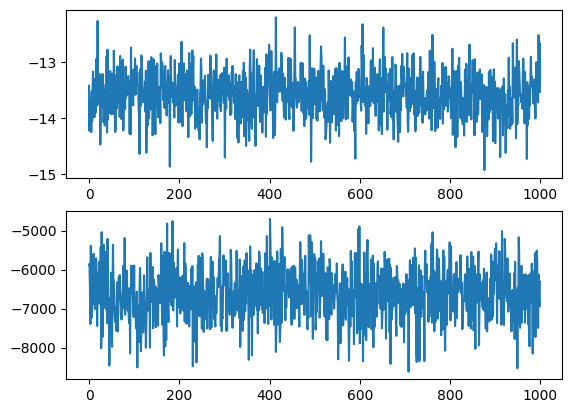

In [179]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()

axes[0].plot(losses_primal)
#axes[0].axhline(y=opt_lqr, color='r', linestyle='--')
axes[1].plot(losses_dual)
plt.show()

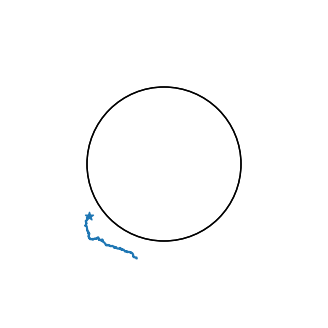

In [190]:
T = 200
states, actions = sampler.sample_trajectory(K, T)
fix, ax = plt.subplots(figsize=[4, 4])

circle_1 = plt.Circle( (0, 0 ), 10 , fill = False )
circle_2 = plt.Circle( (0, 0 ), 10 , fill = False )

ax.set_aspect( 1 )
ax.add_artist(circle_1)
ax.add_artist(circle_2)

plt.scatter(states[-1, 0], states[-1, 1], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.axis('off')
plt.show()

In [254]:
epochs = 1000
n_pe = 100
n_rho = 1_000
n_roll = 200

gamma = 0.95
eta = 0.001

b = - 250.0

env = RobotWorld(range_pos=[-10., 10.], range_vel=[-.1, .1])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, lmbda, losses_primal, losses_dual = dpgpd.train_constrained(epochs, n_pe, n_rho, n_roll)

In [338]:
K, lmbda, losses_primal, losses_dual = dpgpd.resume_training(K, lmbda, losses_primal, losses_dual, epochs, n_pe, n_rho, n_roll)

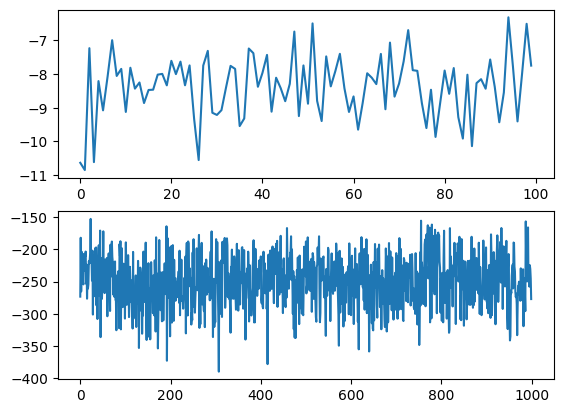

In [258]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()

axes[0].plot(losses_primal)
#axes[0].axhline(y=opt_lqr, color='r', linestyle='--')
axes[1].plot(losses_dual)
plt.show()

In [215]:
np.save('../results/ring_primal.npy', losses_primal)
np.save('../results/ring_dual.npy', losses_dual)

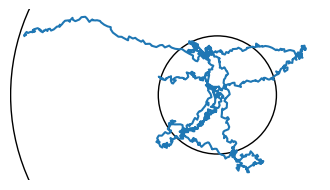

In [274]:
T = 1000
states, actions = sampler.sample_trajectory(K, T)
fix, ax = plt.subplots(figsize=[4, 4])

circle_1 = plt.Circle( (0, 0 ), 7 , fill = False )
circle_2 = plt.Circle( (0, 0 ), 2 , fill = False )

ax.set_aspect( 1 )
ax.add_artist(circle_1)
ax.add_artist(circle_2)

plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
#plt.xlim(-10, 10)
#plt.ylim(-10, 10)
plt.axis('off')
plt.show()